
# Thinkful Capstone 3 | NYC Seasonal Property Sales Assessment


## Introduction


Anyone who has lived in New York City for a substantial amount of time can attest to the amusing sight that occurs every summer, when New Yorkers can be seen moving flat-screen TVs via bicycles or lugging sectional sofas down into the subways. As temperatures rise, it seems as though half the city is packing up their posessions and luggings them through the streets to a new dwelling.

Of course, most of these annual migrants are renters, as approximately 2/3 of all housing units in NYC are renter-occupied. But as of 2017 there were still over 1 million owner-occupied housing units. It stands to reason that property owners should tend to sell property and choose times to move according to the same trends as renters. The warm summer months alleviates the burden of dirty, slush filled streets and frigid wind tunnels, making the moving process easier to manage. If this assumption holds true, then it would follow that there would be more demand for property in the warmer months and that this increased demand would drive prices up. 

The New York City Department of Finance releases property sales data on a monthly basis for property sales that occured in the previous 12 months across all five boroughs of the city. The data includes technical information about the property as well as the sale price and sale date. This data provides an opportunity to examine how sale prices fluctuate depending on the time of year.

In the following analysis I will use a second-hand copy of the NYC Department of Finance's property sales data to look at a single 12 month period and determine if sale prices are, in fact, higher during warmer months in each of the five boroughs.


## The Data Set


I discovered this data set on [Kaggle](https://www.kaggle.com/new-york-city/nyc-property-sales) but it originally comes from the NYC Department of Finance's [Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page). The columns in the data set that will be of interest for this analysis are as follows:
<br></br>
- **Borough**: The borough the property is located in.
  - 1 = Manhattan
  - 2 = Bronx
  - 3 = Brooklyn
  - 4 = Queens
  - 5 = Staten Island
- **Gross Square Feet**: Total area of all the floors of a building as measured from the exterior surfaces of the outside walls of the building, including the land area and space within any building or structure on the property.
- **Sale Price**: Price paid for the property.
- **Sale Date**: Date the property sold.
<br></br>
For full column descriptions the DOF website also provides a [Glossary of Terms](https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf) for their property sales files.


## Preparing the Data



### Importing


First we will import all the necessary libraries, mount my Google Drive, and load the initial CSV file into a Pandas DataFrame.

In [ ]:
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sales_df = pd.read_csv('/content/drive/My Drive/nyc-rolling-sales.csv')


### First Look


Now we can take a first look at our DataFrame.

In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

It looks like our inital DataFrame contains 22 columns and 84,548 rows. The columns contain both numeric and string data types and it appears as though there are no null values. The four columns we will be interested in are the *Borough*, *Gross Square Feet*, *Sale Price*, and *Sale Date* columns. Lets take a quick look at some of the entries to get a better sense of the data.

In [ ]:
sales_df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


There are a few things to note here:
<br></br>
1. The first column looks like it's just an index that carried over from Excel. This column should be removed.
<br></br>
2. The *Gross Square Feet*, *Sale Price*, and *Sale Date* columns are all being read as strings. We will need to convert these to numeric and date data types to make use of them.
<br></br>
3. In the *Sale Price* column we see there are missing entries that are represented by a hyphen rather than a null value. We will need to remove or replace these. There may be additional missing entries in other columns that we will need to check for.

<br></br>
To get started let's quickly remove that first column.

In [ ]:
sales_df.drop(columns=sales_df.columns[0], axis=1, inplace=True)
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING CLASS AT PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT NUMBER                84548 non-null  object
 10  ZIP CODE                        84548 non-null  int64 
 11  RESIDENTIAL UNITS               84548 non-null  int64 
 12  COMMERCIAL UNITS                84548 non-null

Before we alter any data types we will need to check for those missing values since those hyphens will prevent us from converting to numeric values. We will first look at the *Sale Price* column since we know it contains missing values. 

In [ ]:
sales_df['SALE PRICE'].describe()

count     84548
unique    10008
top         -  
freq      14561
Name: SALE PRICE, dtype: object

The most frequent *Sale Price* value is the hyphen and it occurs 14,561 times. Our analysis is going to rely heavily on the sale price so we have no choice but to drop all the rows that are missing a sale price. We will also go ahead and convert the data to numeric values.

In [ ]:
sales_df = sales_df[sales_df['SALE PRICE'].str.contains(" -  ")==False]

In [ ]:
sales_df['SALE PRICE'] = pd.to_numeric(sales_df.loc[:, ('SALE PRICE')])

In [ ]:
sales_df['SALE PRICE'].describe()

count    6.998700e+04
mean     1.276456e+06
std      1.140526e+07
min      0.000000e+00
25%      2.250000e+05
50%      5.300000e+05
75%      9.500000e+05
max      2.210000e+09
Name: SALE PRICE, dtype: float64

Next we will look at the *Gross Square Feet* column to check for missing entries.

In [ ]:
sales_df['GROSS SQUARE FEET'].describe()

count     69987
unique     5095
top         -  
freq      21739
Name: GROSS SQUARE FEET, dtype: object

Again we see the *Gross Square Feet* column contains 21,739 missing values. We will remove these as well and then convert the data to numeric values.

In [ ]:
sales_df = sales_df[sales_df['GROSS SQUARE FEET'].str.contains(" -  ")==False]

In [ ]:
sales_df['GROSS SQUARE FEET'] = pd.to_numeric(sales_df.loc[:, ('GROSS SQUARE FEET')])

In [ ]:
sales_df['GROSS SQUARE FEET'].describe()

count    4.824800e+04
mean     3.672552e+03
std      2.947540e+04
min      0.000000e+00
25%      8.280000e+02
50%      1.620000e+03
75%      2.520000e+03
max      3.750565e+06
Name: GROSS SQUARE FEET, dtype: float64

Lastly we can convert the *Sale Date* column to datetime format.

In [ ]:
sales_df['SALE DATE'] = pd.to_datetime(sales_df.loc[:, ('SALE DATE')])

In [ ]:
sales_df['SALE DATE'].describe(datetime_is_numeric=True)

count                            48248
mean     2017-02-25 15:29:16.723594752
min                2016-09-01 00:00:00
25%                2016-11-29 00:00:00
50%                2017-02-27 00:00:00
75%                2017-05-26 00:00:00
max                2017-08-31 00:00:00
Name: SALE DATE, dtype: object


### Ranges & Outliers

Now that our four columns of interest are all of the correct data types and void of any null or missing values, we can begin taking a closer look at the data in these columns.

In [ ]:
sales_df.loc[:, ('GROSS SQUARE FEET', 'SALE PRICE', 'SALE DATE')].describe(datetime_is_numeric=True)

,GROSS SQUARE FEET,SALE PRICE,SALE DATE
count,4.824800e+04,4.824800e+04,48248
mean,3.672552e+03,1.155576e+06,2017-02-25 15:29:16.723594752
min,0.000000e+00,0.000000e+00,2016-09-01 00:00:00
25%,8.280000e+02,8.056000e+04,2016-11-29 00:00:00
50%,1.620000e+03,4.800000e+05,2017-02-27 00:00:00
75%,2.520000e+03,8.300000e+05,2017-05-26 00:00:00
max,3.750565e+06,2.210000e+09,2017-08-31 00:00:00
std,2.947540e+04,1.340423e+07,NaN


What immediately stands out here is the minimum value in the *Gross Square Feet* and *Sale Price* columns. 
<br></br>
Many property sales occur with a nonsensically small dollar amount, or often $0. These are actually transfers of deeds between parties, such as a parent transfering ownership to their children. We can start addressing these by removing any entries with a sale price of \$0.
<br></br>
Interestingly, there are also entries that are entered as 0 square feet. I'm unsure of the reason for this, but we will go ahead and remove these entries as well.



In [ ]:
sales_df = sales_df[sales_df['SALE PRICE'] != 0]
sales_df = sales_df[sales_df['GROSS SQUARE FEET'] != 0]

In [ ]:
sales_df.loc[:, ('GROSS SQUARE FEET', 'SALE PRICE', 'SALE DATE')].describe(datetime_is_numeric=True)

,GROSS SQUARE FEET,SALE PRICE,SALE DATE
count,2.933400e+04,2.933400e+04,29334
mean,4.632911e+03,1.642829e+06,2017-02-25 08:10:00.859071232
min,1.200000e+02,1.000000e+00,2016-09-01 00:00:00
25%,1.361250e+03,4.200000e+05,2016-11-29 00:00:00
50%,1.874000e+03,6.200000e+05,2017-02-24 12:00:00
75%,2.680000e+03,9.500000e+05,2017-05-26 00:00:00
max,3.750565e+06,2.210000e+09,2017-08-31 00:00:00
std,3.417342e+04,1.699835e+07,NaN


We now have a minimum square footage of 120sqft and a minimum sale price of $1. These values still seem unusually low, but they will be satifactory for the purpose of calculating the price-per-square-foot (PPSQFT) of the properties. 
<br></br>
For context, price-per-square-feet is going to be a more useful dependent variable to test how all property sale prices change depending on the time of year. The sale prices alone are subject to the bias that maybe higher or lower-valued homes sell more frequently at a certain time of year, causing the mean sale price to skew. By looking only at price-per-square-foot, we remove the potential for such bias and focus on the date dependency of price.

In [ ]:
sales_df = sales_df.assign(PPSQFT= sales_df['SALE PRICE']/sales_df['GROSS SQUARE FEET'])

In [ ]:
sales_df['PPSQFT'].describe()

count    29334.000000
mean       410.249141
std        657.105820
min          0.000002
25%        234.009156
50%        343.465124
75%        487.280195
max      75974.855000
Name: PPSQFT, dtype: float64

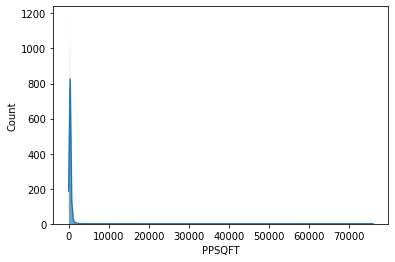

In [ ]:
sns.histplot(data=sales_df, kde=True, x='PPSQFT', bins=5000)

Clearly the *PPSQFT* data is heavily skewed. 75% of the values are below \$488 so lets check exactly how many entires have a PPSQFT over \$2000.

In [ ]:
ppsqft_over_2k = sales_df.loc[sales_df['PPSQFT'] > 2000]
print(ppsqft_over_2k['PPSQFT'].count())

201


Less than 1% of the total entries have a PPSQFT over \$2000/sqft, lets go ahead and remove these and look at the distribution again.

In [ ]:
sales_df = sales_df[sales_df['PPSQFT'] < 2000]
sales_df['PPSQFT'].describe()

count    29131.000000
mean       383.158263
std        249.113772
min          0.000002
25%        233.099377
50%        342.261905
75%        483.119723
max       1995.370370
Name: PPSQFT, dtype: float64

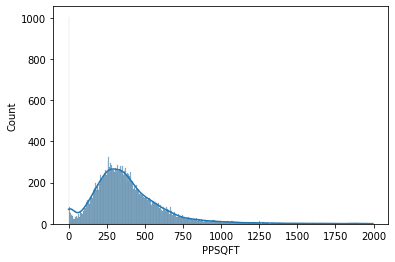

In [ ]:
sns.histplot(data=sales_df, kde=True, x='PPSQFT', bins=500)

The distribution is looking much better after removing those upper outliers, but we may still be able to remove a few more entries off the top. We will check for entries with a PPSQFT above 3 standard deviations from the mean. 

In [ ]:
price_above_3std = sales_df.loc[sales_df['PPSQFT'] > sales_df['PPSQFT'].mean() + 3*sales_df['PPSQFT'].std()]
print(price_above_3std['PPSQFT'].count())

512


We will go ahead and remove these as well.

In [ ]:
sales_df = sales_df[sales_df['PPSQFT'] < sales_df['PPSQFT'].mean() + 3*sales_df['PPSQFT'].std()]
sales_df['PPSQFT'].describe()

count    28619.000000
mean       364.283623
std        204.529581
min          0.000002
25%        230.823178
50%        338.345865
75%        472.238620
max       1130.307199
Name: PPSQFT, dtype: float64

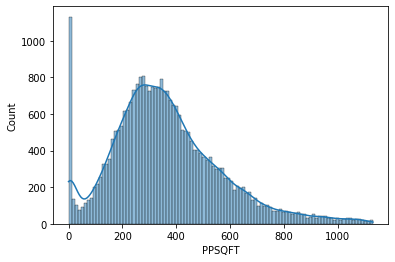

In [ ]:
sns.histplot(data=sales_df, kde=True, x='PPSQFT', bins=100)

Now our upper end looks good but we should address that spike at the low end of the distribution. Those entries are left over from the deed transfers that I mentioned before. We previously removed the properties that sold for \$0 but sometime these transfers occur with a sale price of \$10, \$50, \$200, etc. It will be easier to consider outliers in the *Sale Price* values, lets check homes that sold for under $1000.

In [ ]:
price_under_1k = sales_df[sales_df['SALE PRICE'] < 1000]
print(price_under_1k['SALE PRICE'].count())

790


Lets remove these and take a look at the *PPSQFT* distribution again.

In [ ]:
sales_df = sales_df[sales_df['SALE PRICE'] > 1000]

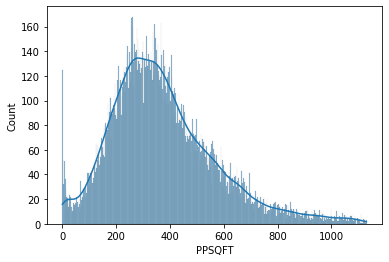

In [ ]:
sns.histplot(data=sales_df, kde=True, x='PPSQFT', binwidth=2)

We still have a spike at the bottom end of the distribution, lets check how many properties have a PPSQFT under \$3/sqft.

In [ ]:
ppsqft_under_3 = sales_df[sales_df['PPSQFT'] < 3]
print('Number of entries with PPSQFT < 3 = {}'.format(ppsqft_under_3['PPSQFT'].count()))
ppsqft_under_3['PPSQFT'].sort_values()

Number of entries with PPSQFT < 3 = 154


12539    0.025853
9672     0.053141
9670     0.078946
9677     0.088613
16967    0.112340
           ...   
2062     2.768514
34087    2.777778
70429    2.815278
35112    2.857143
21836    2.942042
Name: PPSQFT, Length: 154, dtype: float64

We will remove these and check the distribution again.

In [ ]:
sales_df = sales_df[sales_df['PPSQFT'] > 3]
sales_df['PPSQFT'].describe()

count    27634.000000
mean       377.260385
std        196.037199
min          3.048780
25%        242.962749
50%        345.583657
75%        479.335901
max       1130.307199
Name: PPSQFT, dtype: float64

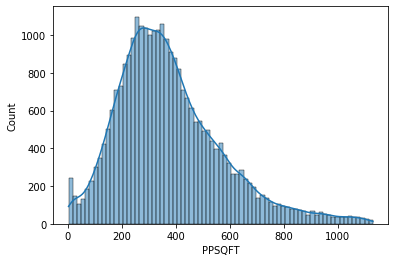

In [ ]:
sns.histplot(data=sales_df, kde=True, x='PPSQFT')

Our PPSQFT distribution looks good enough to work with. The last thing we need to do before we begin our analysis is take a look at the property sales according to the borough the property is located in and the date the property sold.


### Creating Bins


First we will create bins for property sales according to the borough the property is located in.

In [ ]:
manhattan = sales_df[sales_df['BOROUGH'] == 1]
bronx = sales_df[sales_df['BOROUGH'] == 2]
brooklyn = sales_df[sales_df['BOROUGH'] == 3]
queens = sales_df[sales_df['BOROUGH'] == 4]
staten = sales_df[sales_df['BOROUGH'] == 5]

In [ ]:
manhattan_n = manhattan['PPSQFT'].count()
bronx_n = bronx['PPSQFT'].count()
brooklyn_n = brooklyn['PPSQFT'].count()
queens_n = queens['PPSQFT'].count()
staten_n = staten['PPSQFT'].count()

print('Number of Manhattan sales = {}.'.format(manhattan_n))
print('Number of Bronx sales = {}.'.format(bronx_n))
print('Number of Brooklyn sales = {}.'.format(brooklyn_n))
print('Number of Queens sales = {}.'.format(queens_n))
print('Number of Staten Island sales = {}.'.format(staten_n))

Number of Manhattan sales = 606.
Number of Bronx sales = 3380.
Number of Brooklyn sales = 8034.
Number of Queens sales = 10697.
Number of Staten Island sales = 4917.


Looks like we have good sample sizes for each borough, although the sample size for Manhattan is significantly smaller than the other boroughs. Next we will split these bins according to sale date. For each borough, we will have one bin for properties that sold between September 1, 2016 and February 28, 2017 and another bin for properties that sold between March 1, 2017 and August 31, 2017. We will label these bins *borough_winter* and *borough_summer* respectively.

In [ ]:
manhattan_winter = sales_df[(sales_df['BOROUGH'] == 1) & (sales_df['SALE DATE'] <= '2017-02-28')]
manhattan_summer = sales_df[(sales_df['BOROUGH'] == 1) & (sales_df['SALE DATE'] >= '2017-03-01')]

bronx_winter = sales_df[(sales_df['BOROUGH'] == 2) & (sales_df['SALE DATE'] <= '2017-02-28')]
bronx_summer = sales_df[(sales_df['BOROUGH'] == 2) & (sales_df['SALE DATE'] >= '2017-03-01')]

brooklyn_winter = sales_df[(sales_df['BOROUGH'] == 3) & (sales_df['SALE DATE'] <= '2017-02-28')]
brooklyn_summer = sales_df[(sales_df['BOROUGH'] == 3) & (sales_df['SALE DATE'] >= '2017-03-01')]

queens_winter = sales_df[(sales_df['BOROUGH'] == 4) & (sales_df['SALE DATE'] <= '2017-02-28')]
queens_summer = sales_df[(sales_df['BOROUGH'] == 4) & (sales_df['SALE DATE'] >= '2017-03-01')]

staten_winter = sales_df[(sales_df['BOROUGH'] == 5) & (sales_df['SALE DATE'] <= '2017-02-28')]
staten_summer = sales_df[(sales_df['BOROUGH'] == 5) & (sales_df['SALE DATE'] >= '2017-03-01')]

In [ ]:
manhattan_winter_n = manhattan_winter['PPSQFT'].count()
manhattan_summer_n = manhattan_summer['PPSQFT'].count()

bronx_winter_n = bronx_winter['PPSQFT'].count()
bronx_summer_n = bronx_summer['PPSQFT'].count()

brooklyn_winter_n = brooklyn_winter['PPSQFT'].count()
brooklyn_summer_n = brooklyn_summer['PPSQFT'].count()

queens_winter_n = queens_winter['PPSQFT'].count()
queens_summer_n = queens_summer['PPSQFT'].count()

staten_winter_n = staten_winter['PPSQFT'].count()
staten_summer_n = staten_summer['PPSQFT'].count()

In [ ]:
print('Number of Manhattan winter sales = {}.'.format(manhattan_winter_n))
print('Number of Manhattan summer sales = {}.'.format(manhattan_summer_n))
print('')
print('Number of Bronx winter sales = {}.'.format(bronx_winter_n))
print('Number of Bronx summer sales = {}.'.format(bronx_summer_n))
print('')
print('Number of Brooklyn winter sales = {}.'.format(brooklyn_winter_n))
print('Number of Brooklyn summer sales = {}.'.format(brooklyn_summer_n))
print('')
print('Number of Queens winter sales = {}.'.format(queens_winter_n))
print('Number of Queens summer sales = {}.'.format(queens_summer_n))
print('')
print('Number of Staten Island winter sales = {}.'.format(staten_winter_n))
print('Number of Staten Island summer sales = {}.'.format(staten_summer_n))

Number of Manhattan winter sales = 358.
Number of Manhattan summer sales = 248.

Number of Bronx winter sales = 1683.
Number of Bronx summer sales = 1697.

Number of Brooklyn winter sales = 4064.
Number of Brooklyn summer sales = 3970.

Number of Queens winter sales = 5376.
Number of Queens summer sales = 5321.

Number of Staten Island winter sales = 2637.
Number of Staten Island summer sales = 2280.


Now that the data is cleaned and organized, we are ready to begin our analysis.


## Research Questions & Hypotheses


**Question 1**: Is there a difference between the sale prices of Manhattan properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Manhattan properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Manhattan properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

<br></br>
**Question 2**: Is there a difference between the sale prices of Bronx properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Bronx properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Bronx properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

<br></br>
**Question 3**: Is there a difference between the sale prices of Brooklyn properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Brooklyn properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Brooklyn properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

<br></br>
**Question 4**: Is there a difference between the sale prices of Queens properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Queens properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Queens properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

<br></br>
**Question 5**: Is there a difference between the sale prices of Staten Island properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Staten Island properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Staten Island properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.




## Analysis


### Manhattan


**Question 1**: Is there a difference between the sale prices of Manhattan properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Manhattan properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Manhattan properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

---

Before we perform any statistical tests, lets look at the descriptive stats and distribution for our two samples.


In [ ]:
print('Descriptive Stats: manhattan_winter')
print(manhattan_winter['PPSQFT'].describe())

Descriptive Stats: manhattan_winter
count     358.000000
mean      572.642657
std       290.829415
min         4.464286
25%       374.080745
50%       566.182896
75%       793.977809
max      1130.307199
Name: PPSQFT, dtype: float64


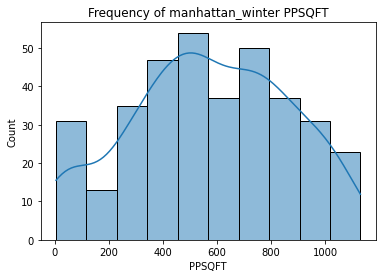

In [ ]:
sns.histplot(data=manhattan_winter, kde=True, x='PPSQFT')
plt.title('Frequency of manhattan_winter PPSQFT')
plt.show()

In [ ]:
print('Descriptive Stats: manhattan_summer')
print(manhattan_summer['PPSQFT'].describe())

Descriptive Stats: manhattan_summer
count     248.000000
mean      589.769684
std       298.167016
min         5.296204
25%       375.968598
50%       602.915316
75%       827.485611
max      1124.016486
Name: PPSQFT, dtype: float64


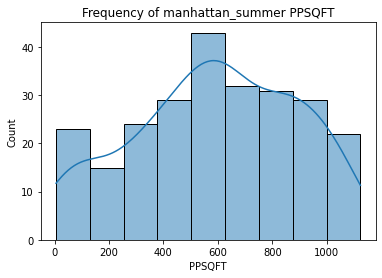

In [ ]:
sns.histplot(data=manhattan_summer, kde=True, x='PPSQFT')
plt.title('Frequency of manhattan_summer PPSQFT')
plt.show()

These aren't the best looking distributions, but considering Manhattan had the smallest sample sizes, this will be sufficient for our test. Now we will conduct an independent sample t-test on the mean PPSQFT with α = .05.

In [ ]:
manhattan_winter_mean = manhattan_winter['PPSQFT'].mean()
manhattan_summer_mean = manhattan_summer['PPSQFT'].mean()
manhattan_mean_diff = manhattan_winter_mean-manhattan_summer_mean

manhattan_z, manhattan_p = stats.ttest_ind(manhattan_winter['PPSQFT'], manhattan_summer['PPSQFT'])
print('Sample Means: \n manhattan_winter = {} \n manhattan_summer = {}'.format(manhattan_winter_mean, manhattan_summer_mean))
print('')
print('Sample Mean Difference = {}'.format(manhattan_mean_diff))
print('')
print('Test Results: \n z-stat = {} \n p-value = {}'.format(manhattan_z, manhattan_p))

Sample Means: 
 manhattan_winter = 572.6426565187757 
 manhattan_summer = 589.7696841600415

Sample Mean Difference = -17.12702764126584

Test Results: 
 z-stat = -0.7054790046302419 
 p-value = 0.4807841755744182


The test resulted in a p-value of 0.48 which is greater than our α-level of 0.05. 
<br></br>
We fail to reject the null hypothesis that the mean PPSQFT of Manhattan properties sold between September-February are equal to those sold between March-August. The sample mean difference is not statistically significant at the α=.05 level.
<br></br>
In other words, the sample mean difference of \$-17.13/sqft cannot be shown to be representative of Manhattan properties as a whole.


### Bronx


**Question 2**: Is there a difference between the sale prices of Bronx properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Bronx properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Bronx properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

---

Again, we will check the descriptive stats and the distributions for our two samples.

In [ ]:
print('Descriptive Stats: bronx_winter')
print(bronx_winter['PPSQFT'].describe())

Descriptive Stats: bronx_winter
count    1683.000000
mean      231.981594
std       111.994844
min         3.631082
25%       161.687483
50%       217.601547
75%       280.370102
max      1041.666667
Name: PPSQFT, dtype: float64


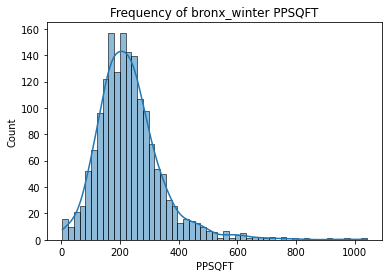

In [ ]:
sns.histplot(data=bronx_winter, kde=True, x='PPSQFT')
plt.title('Frequency of bronx_winter PPSQFT')
plt.show()

In [ ]:
print('Descriptive Stats: bronx_summer')
print(bronx_summer['PPSQFT'].describe())

Descriptive Stats: bronx_summer
count    1697.000000
mean      243.709672
std       122.491868
min         3.086420
25%       169.722380
50%       227.029915
75%       288.461538
max      1089.423513
Name: PPSQFT, dtype: float64


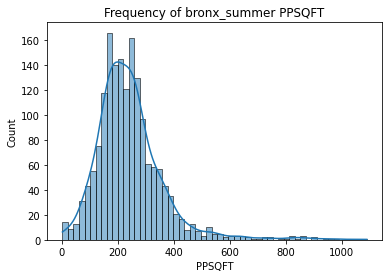

In [ ]:
sns.histplot(data=bronx_summer, kde=True, x='PPSQFT')
plt.title('Frequency of bronx_summer PPSQFT')
plt.show()

Our distributions look sufficient for our test so we will go ahead with another independent sample t-test on the PPSQFT means with α = .05.

In [ ]:
bronx_winter_mean = bronx_winter['PPSQFT'].mean()
bronx_summer_mean = bronx_summer['PPSQFT'].mean()
bronx_mean_diff = bronx_winter_mean-bronx_summer_mean

bronx_z, bronx_p = stats.ttest_ind(bronx_winter['PPSQFT'], bronx_summer['PPSQFT'])
print('Sample Means: \n bronx_winter = {} \n bronx_summer = {}'.format(bronx_winter_mean, bronx_summer_mean))
print('')
print('Sample Mean Difference = {}'.format(bronx_mean_diff))
print('')
print('Test Results: \n z-stat = {} \n p-value = {}'.format(bronx_z, bronx_p))

Sample Means: 
 bronx_winter = 231.98159385230633 
 bronx_summer = 243.7096720104657

Sample Mean Difference = -11.728078158159377

Test Results: 
 z-stat = -2.9043444019449653 
 p-value = 0.003704111653644145


The test resulted in a p-value of 0.004 which is less than our α-level of 0.05. We are forced to reject the null hypothesis that the population means are equal. The sample mean difference is statistically significant at the α = .05 level.<br></br>
This test has concluded that Bronx properties sold between September-February do sell for less than those sold between March-August. To see the magnitude of the difference let's check the 95% confidence interval for the mean difference.

In [ ]:
bronx_winter_var = bronx_winter['PPSQFT'].var()
bronx_summer_var = bronx_summer['PPSQFT'].var()

bronx_std_err_diff = math.sqrt((bronx_winter_var/bronx_winter_n)+(bronx_summer_var/bronx_summer_n))
bronx_margin_of_err = 1.96 * bronx_std_err_diff

bronx_ci_lower = bronx_mean_diff - bronx_margin_of_err
bronx_ci_upper = bronx_mean_diff + bronx_margin_of_err

print('95% Confidence Interval for bronx_mean_diff: \n Lower Bound = {} \n Upper Bound = {}'.format(bronx_ci_lower, bronx_ci_upper))

95% Confidence Interval for bronx_mean_diff: 
 Lower Bound = -19.63985498349154 
 Upper Bound = -3.816301332827215


At the 95% confidence level, the population mean difference is between \$-19.64/sqft and \$-3.82/sqft. 
<br></br>
So with 95% confidence, Bronx properties sold between March-August sell for \$3.82 to \$19.64 more on average than those sold between September-February.


### Brooklyn


**Question 3**: Is there a difference between the sale prices of Brooklyn properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Brooklyn properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Brooklyn properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

---

We start by checking descriptive stats and distributions.


In [ ]:
print('Descriptive Stats: brooklyn_winter')
print(brooklyn_winter['PPSQFT'].describe())

Descriptive Stats: brooklyn_winter
count    4064.000000
mean      416.540145
std       218.822127
min         3.048780
25%       262.129264
50%       388.078847
75%       533.333333
max      1125.000000
Name: PPSQFT, dtype: float64


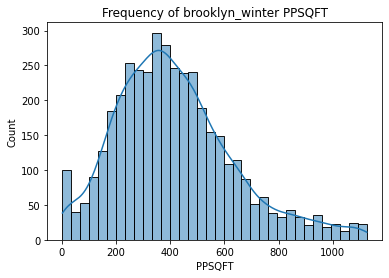

In [ ]:
sns.histplot(data=brooklyn_winter, kde=True, x='PPSQFT')
plt.title('Frequency of brooklyn_winter PPSQFT')
plt.show()

In [ ]:
print('Descriptive Stats: brooklyn_summer')
print(brooklyn_summer['PPSQFT'].describe())

Descriptive Stats: brooklyn_summer
count    3970.000000
mean      435.817742
std       230.114641
min         3.089280
25%       268.907563
50%       400.000000
75%       571.354461
max      1129.943503
Name: PPSQFT, dtype: float64


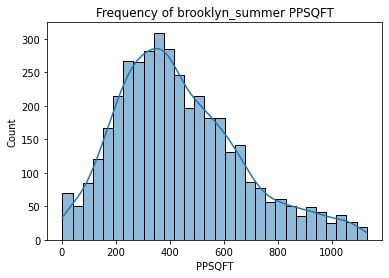

In [ ]:
sns.histplot(data=brooklyn_summer, kde=True, x='PPSQFT')
plt.title('Frequency of brooklyn_summer PPSQFT')
plt.show()

The distributions look good, we can move onto our t-test.

In [ ]:
brooklyn_winter_mean = brooklyn_winter['PPSQFT'].mean()
brooklyn_summer_mean = brooklyn_summer['PPSQFT'].mean()
brooklyn_mean_diff = brooklyn_winter_mean-brooklyn_summer_mean

brooklyn_z, brooklyn_p = stats.ttest_ind(brooklyn_winter['PPSQFT'], brooklyn_summer['PPSQFT'])
print('Sample Means: \n brooklyn_winter = {} \n brooklyn_summer = {}'.format(brooklyn_winter_mean, brooklyn_summer_mean))
print('')
print('Sample Mean Difference = {}'.format(brooklyn_mean_diff))
print('')
print('Test Results: \n z-stat = {} \n p-value = {}'.format(brooklyn_z, brooklyn_p))

Sample Means: 
 brooklyn_winter = 416.54014488279 
 brooklyn_summer = 435.8177418079933

Sample Mean Difference = -19.277596925203284

Test Results: 
 z-stat = -3.8485254290143245 
 p-value = 0.00011975199141203575


Our test results show a p-value of 0.0001 which is significantly less than the α-level of 0.05. We must reject the null hypothesis that the population means are equal. The sample mean difference of \$-19.28/sqft is statistically significant at the α = 0.05 level.
<br></br>
The test concluded that the Brooklyn properties sold between September-February do sell for less than those sold between March-August. Let's check the confidence interval to understand the magnitude of this effect.

In [ ]:
brooklyn_winter_var = brooklyn_winter['PPSQFT'].var()
brooklyn_summer_var = brooklyn_summer['PPSQFT'].var()

brooklyn_std_err_diff = math.sqrt((brooklyn_winter_var/brooklyn_winter_n)+(brooklyn_summer_var/brooklyn_summer_n))
brooklyn_margin_of_err = 1.96 * brooklyn_std_err_diff

brooklyn_ci_lower = brooklyn_mean_diff - brooklyn_margin_of_err
brooklyn_ci_upper = brooklyn_mean_diff + brooklyn_margin_of_err

print('95% Confidence Interval for brooklyn_mean_diff: \n Lower Bound = {} \n Upper Bound = {}'.format(brooklyn_ci_lower, brooklyn_ci_upper))

95% Confidence Interval for brooklyn_mean_diff: 
 Lower Bound = -29.10118422115919 
 Upper Bound = -9.454009629247377


At the 95% confidence level the population mean difference is between \$-29.10/sqft and \$-9.45/sqft.
<br></br>
So with 95% certainty we can expect Brooklyn properties sold between March-August to sell for \$9.45 to \$29.10 more on average than those sold between September-February.


### Queens


**Question 4**: Is there a difference between the sale prices of Queens properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Queens properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Queens properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

---

Let's check the descriptive stats and sample distributions.

In [ ]:
print('Descriptive Stats: queens_winter')
print(queens_winter['PPSQFT'].describe())

Descriptive Stats: queens_winter
count    5376.000000
mean      396.325318
std       177.548235
min         3.152585
25%       277.091030
50%       377.404735
75%       502.136535
max      1128.472222
Name: PPSQFT, dtype: float64


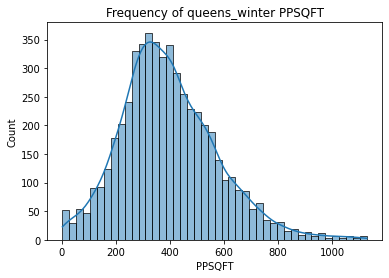

In [ ]:
sns.histplot(data=queens_winter, kde=True, x='PPSQFT')
plt.title('Frequency of queens_winter PPSQFT')
plt.show()

In [ ]:
print('Descriptive Stats: queens_summer')
print(queens_summer['PPSQFT'].describe())

Descriptive Stats: queens_summer
count    5321.000000
mean      402.420130
std       183.648163
min         3.181818
25%       275.000000
50%       384.399551
75%       513.157895
max      1130.208333
Name: PPSQFT, dtype: float64


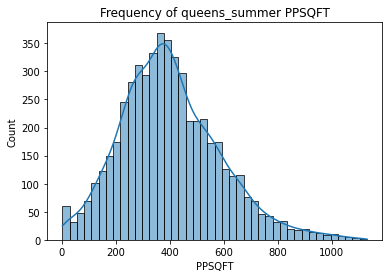

In [ ]:
sns.histplot(data=queens_summer, kde=True, x='PPSQFT')
plt.title('Frequency of queens_summer PPSQFT')
plt.show()

Our samples look sufficient, let's move on to the t-test.

In [ ]:
queens_winter_mean = queens_winter['PPSQFT'].mean()
queens_summer_mean = queens_summer['PPSQFT'].mean()
queens_mean_diff = queens_winter_mean-queens_summer_mean

queens_z, queens_p = stats.ttest_ind(queens_winter['PPSQFT'], queens_summer['PPSQFT'])
print('Sample Means: \n queens_winter = {} \n queens_summer = {}'.format(queens_winter_mean, queens_summer_mean))
print('')
print('Sample Mean Difference = {}'.format(queens_mean_diff))
print('')
print('Test Results: \n z-stat = {} \n p-value = {}'.format(queens_z, queens_p))

Sample Means: 
 queens_winter = 396.32531817736697 
 queens_summer = 402.420129776218

Sample Mean Difference = -6.094811598851038

Test Results: 
 z-stat = -1.745090357616848 
 p-value = 0.08099786183056616


Our test results show a p-value of 0.08 which is greater than our α-level of 0.05. 
<br></br>
We fail to reject the null hypothesis that the population means are equal. The sample mean difference of \$-6.09/sqft is not statistically significant at the α = .05 level.
<br></br>
In other words, the mean PPSQFT of Queens properties sold between September-February does not differ from the mean PPSQFT of those sold between March-August. The sample mean difference cannot be shown to be representative of Queens properties as a whole.


### Staten Island


**Question 5**: Is there a difference between the sale prices of Staten Island properties sold between September-February and those sold between March-August?

> **H<sub>0</sub>** : The mean PPSQFT of Staten Island properties sold between September-February ***is equal*** to the mean PPSQFT of those sold between March-August.

> **H<sub>a</sub>** : The mean PPSQFT of Staten Island properties sold between September-February ***is not equal*** to the mean PPSQFT of those sold between March-August.

---

We will start with the descriptive stats and distributions for our two samples.


In [ ]:
print('Descriptive Stats: staten_winter')
print(staten_winter['PPSQFT'].describe())

Descriptive Stats: staten_winter
count    2637.000000
mean      311.021813
std       122.729001
min         4.081633
25%       234.680574
50%       302.325581
75%       370.982987
max      1070.652174
Name: PPSQFT, dtype: float64


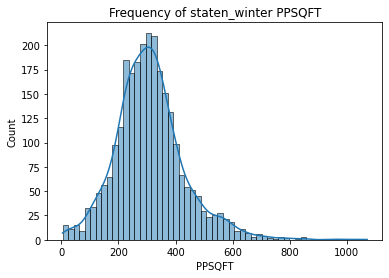

In [ ]:
sns.histplot(data=staten_winter, kde=True, x='PPSQFT')
plt.title('Frequency of staten_winter PPSQFT')
plt.show()

In [ ]:
print('Descriptive Stats: staten_summer')
print(staten_summer['PPSQFT'].describe())

Descriptive Stats: staten_summer
count    2280.000000
mean      331.070911
std       128.568501
min         3.345070
25%       250.258621
50%       322.005257
75%       394.893251
max      1041.666667
Name: PPSQFT, dtype: float64


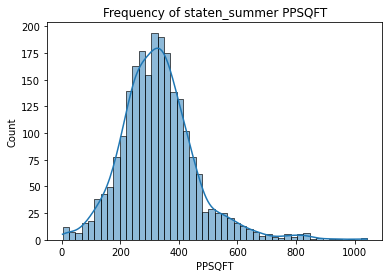

In [ ]:
sns.histplot(data=staten_summer, kde=True, x='PPSQFT')
plt.title('Frequency of staten_summer PPSQFT')
plt.show()

The distributions look sufficient, we can move on to the t-test.

In [ ]:
staten_winter_mean = staten_winter['PPSQFT'].mean()
staten_summer_mean = staten_summer['PPSQFT'].mean()
staten_mean_diff = staten_winter_mean-staten_summer_mean

staten_z, staten_p = stats.ttest_ind(staten_winter['PPSQFT'], staten_summer['PPSQFT'])
print('Sample Means: \n staten_winter = {} \n staten_summer = {}'.format(staten_winter_mean, staten_summer_mean))
print('')
print('Sample Mean Difference = {}'.format(staten_mean_diff))
print('')
print('Test Results: \n z-stat = {} \n p-value = {}'.format(staten_z, staten_p))

Sample Means: 
 staten_winter = 311.02181270679154 
 staten_summer = 331.07091116900307

Sample Mean Difference = -20.049098462211532

Test Results: 
 z-stat = -5.587605012104811 
 p-value = 2.4263168481328495e-08


The results show a p-value of 2.4×10<sup>-8</sup> which is significantly less than our α-level of 0.05. We are forced to reject the null hypothesis that the population PPSQFT means are equal. The sample mean difference of \$-20.05/sqft is statistically significant at the α = .05 level. 
<br></br>
The test concludes that the PPSQFT of Staten Island properties sold between March-August are higher, on average, than those sold between September-February. Let's check the confidence intervals to examine the magnitude of this effect.

In [ ]:
staten_winter_var = staten_winter['PPSQFT'].var()
staten_summer_var = staten_summer['PPSQFT'].var()

staten_std_err_diff = math.sqrt((staten_winter_var/staten_winter_n)+(staten_summer_var/staten_summer_n))
staten_margin_of_err = 1.96 * staten_std_err_diff

staten_ci_lower = staten_mean_diff - staten_margin_of_err
staten_ci_upper = staten_mean_diff + staten_margin_of_err

print('95% Confidence Interval for staten_mean_diff: \n Lower Bound = {} \n Upper Bound = {}'.format(staten_ci_lower, staten_ci_upper))

95% Confidence Interval for staten_mean_diff: 
 Lower Bound = -27.10561203704735 
 Upper Bound = -12.992584887375713


At the 95% confidence level, the population mean difference is between \$-27.11/sqft and \$12.99/sqft. 
<br></br>
We can say with 95% certainty that Staten Island properties sold between March-August sell for \$12.99 to \$27.10 per square foot more, on average, than those sold between September-February.


### Summary


| Borough | Sample Mean Diff | P-Value | Result | Population Mean Diff Confidence Interval |
|:---:|:---:|:---:|:---:|:---:|
| Manhattan | \$17.13/sqft | 0.48 | Fail to reject null hypothesis| N/A |
| Bronx | \$11.73/sqft | 0.003 | Reject null hypothesis | \$3.82/sqft - \$19.64/sqft |
| Brooklyn | \$19.28/sqft | 0.0001 | Reject null hypothesis | \$9.45/sqft - \$29.10/sqft |
| Queens | \$6.09/sqft | 0.08 | Fail to reject null hypothesis | N/A |
| Staten Island| \$20.05/sqft | 2.4 × 10<sup>-8</sup> | Reject null hypothesis | \$12.99/sqft - \$27.11/sqft |


## Insights & Recommendations


The purpose of this analysis was to gain insight into how property sale prices differ between typically colder months (September-February) and warmer months (March-August) within each of the five boroughs of New York City. It was my inital assumption that sale prices would be higher in the warmer months and lower in the colder months. 
<br></br>
The results of our hypothesis tests have shown this to be true in the Bronx, Brooklyn, and Staten Island; However, no such effect was found for property sales in Manhattan or Queens. It's difficult to speculate as to the reason why sale prices would increase during warmer months in only three of the boroughs. Conducting a similar analysis spanning multiple years could shed some light on whether this trend is indicative of just the 2016-17 year, or if the pattern holds over time. 
<br></br>
What we can say is that for property in the Bronx, Brooklyn, and Staten Island, sale prices are higher during the months of March-August than the rest of the year. This means that if you are looking to sell property, look to sell in the Spring or Summer, and if you are looking to buy property, try to buy in the Fall or Winter. In the Bronx properties could sell for nearly \$20 per square foot higher in the Spring or Summer; In Brooklyn, nearly \$30 per square foot higher; And in Staten Island, over \$27 per square foot higher. Considering the average area of all the properties in this data set is over 3,500sqft the difference in sale prices can reach over \$100,000 depending on the time of year the sale takes palce.  
<br></br>
To improve on the insights gained from this research, I recommend similar analyses be conducted on data sets that span multiple years to see if the patterns identified here are consistent from year-to-year. It would also be worth looking at differences in sale prices from month-to-month to get a more detailed picture of the months where sale prices increase.